# Arbitrage in the stock market
In this notebook I will explore the possibility of arbitrage in the stock market. Let's first load a universe of stock from 2010 to 2020.

In [224]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv('../data/processed/combined/' + 'stock_aclose_2010_2020.csv',index_col=0)
print(df.shape)

null_fraction = 0.2
tickers = []
for col in df.columns:
    if null_fraction * len(df[col]) > df[col].isnull().sum():
        tickers.append(col)

df = df[tickers]
print('shape after removing stock with > 80% null')
print(df.shape)

(2516, 5808)
shape after removing stock with > 80% null
(2516, 3522)


# Return distribution
Let's take a look at the return distribution of the stocks.

<IPython.core.display.Javascript object>


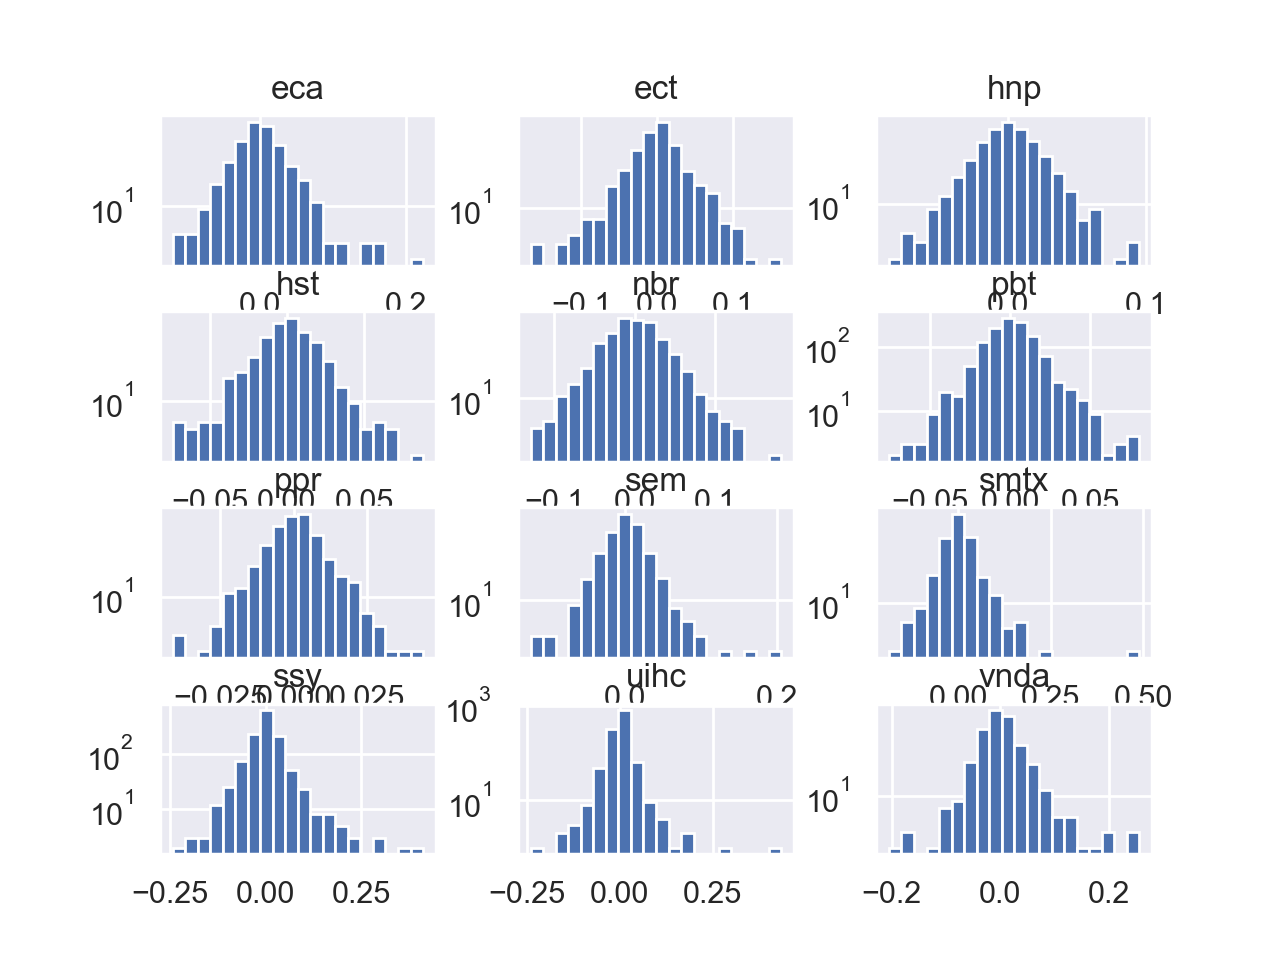

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a32cc65c0>,
      dtype=object)

In [225]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

sns.set()

lag = 1
df_return = df.shift(1).pct_change(lag)[::lag+1] # [::lag+1] This makes sure an investment decision made today 
                                                 # is based on information before today.

# if nan (e.g. stop trading, not listed etc), return will be 0
df_return = df_return.fillna(0)

# randomly choose 10 stocks
df_12_return = df_return.sample(12,axis=1)
df_12_return.hist(log = True, bins=20)


<IPython.core.display.Javascript object>


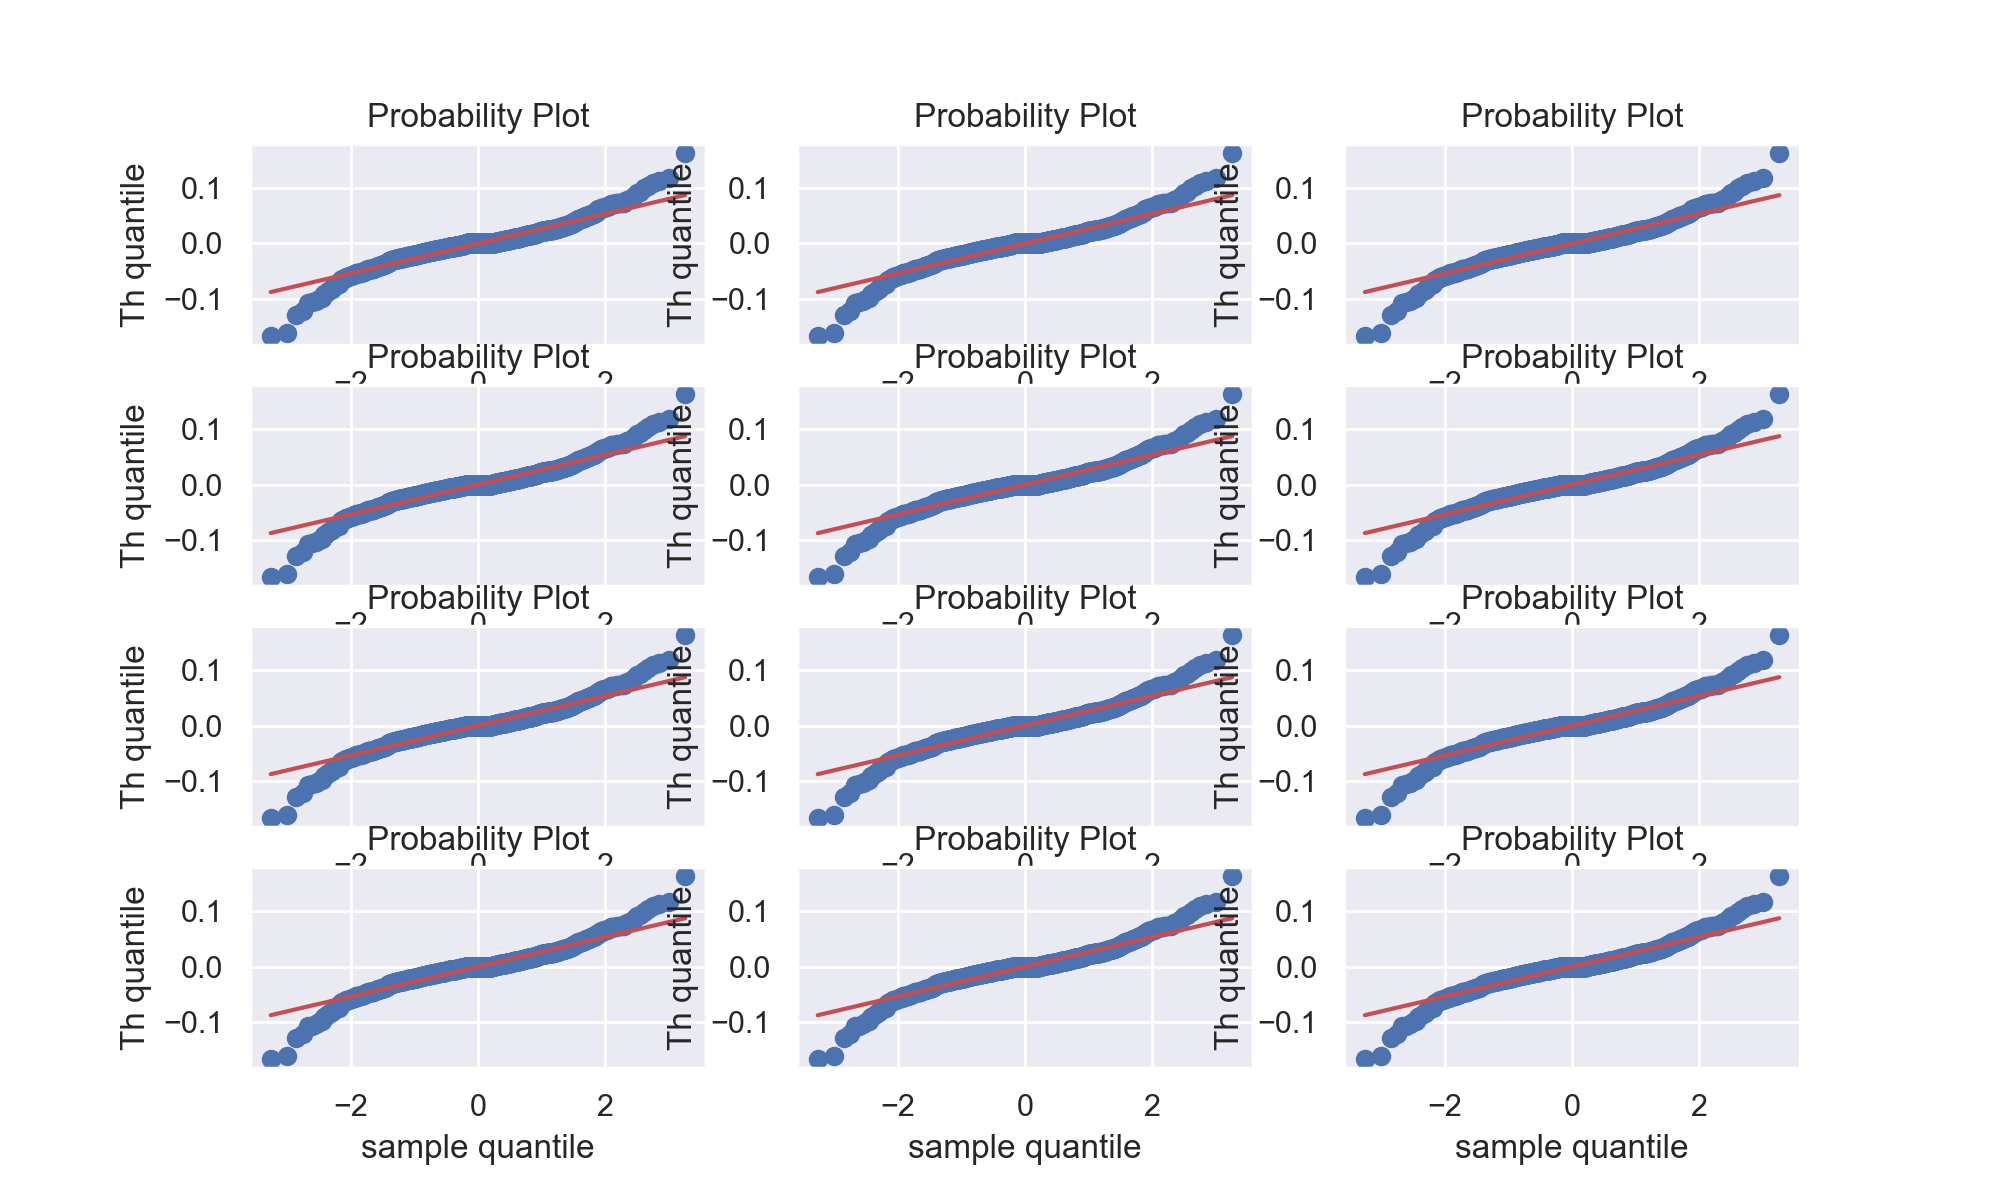

In [226]:
import scipy.stats as stats
import pylab

fig = plt.figure(figsize=(10,6))
for i in range(12):
    ax = fig.add_subplot(4,3,i+1)
    stats.probplot(df_12_return.iloc[:,3], dist="norm",plot=pylab)
    plt.ylabel('Th quantile')
    plt.xlabel('sample quantile')
pylab.show()

The qqplots show that the return has a heavy tail and the distributions are not normal.

# Autocorrelation
The simpliest indication of arbitrage is a non-zero autocorrelation. Let's rank the stocks by their lag-1 autocorrelation. How significant are the autocorrelations? We can do a t-test to see which stocks have genuine non-zero autocorrelation. I plot the p-values of the ranked autocorrelations.

      autocorr
tvc  -0.199779
bpth -0.192572
fpay -0.178822
suns -0.176679
nvfy -0.176149
...        ...
emp   0.151514
linc  0.178337
pir   0.189961
bh    0.199840
inf        NaN

[3522 rows x 1 columns]


<IPython.core.display.Javascript object>


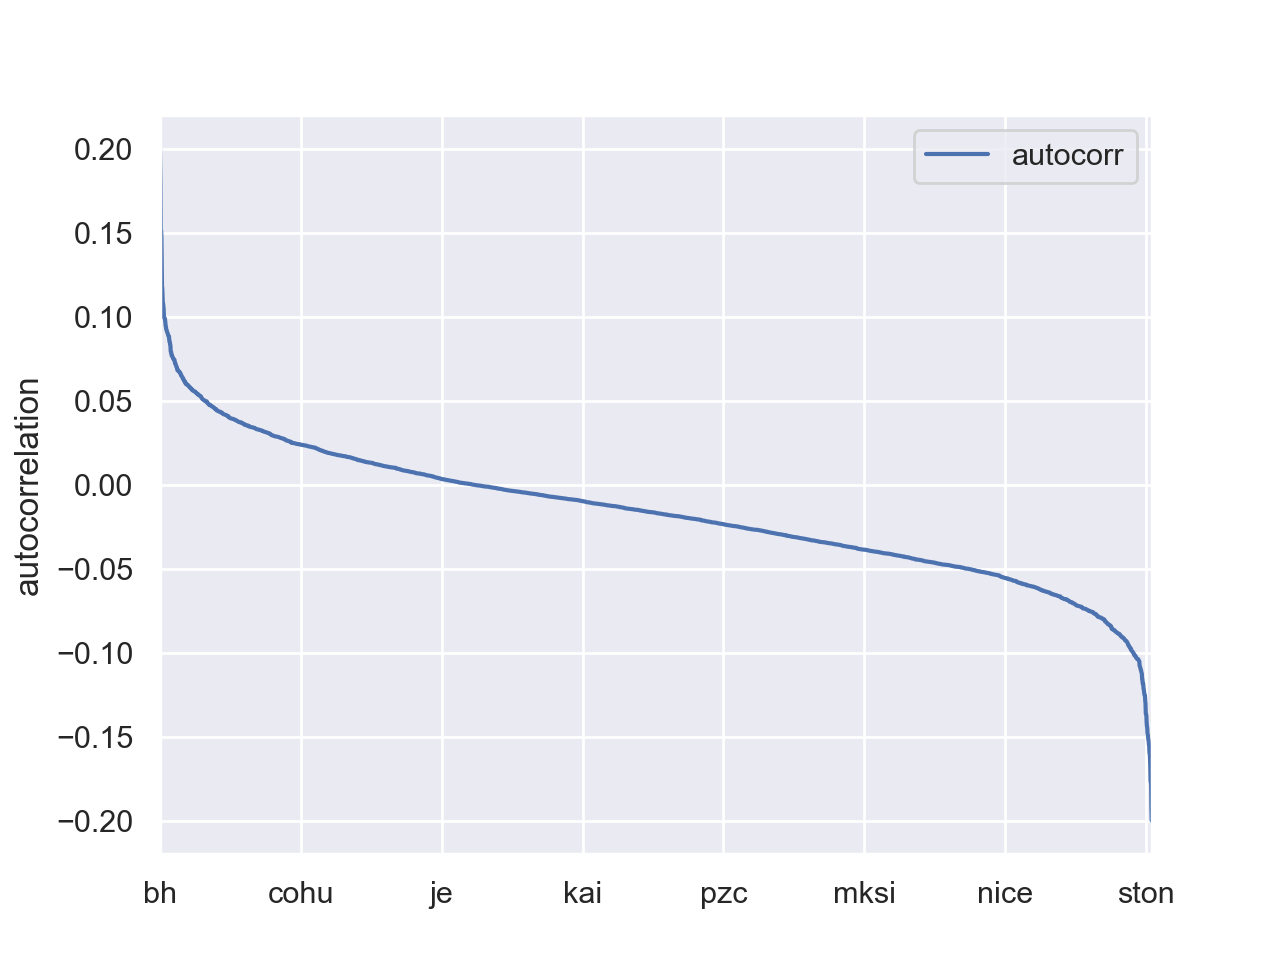

           p-value
bh    4.234391e-13
tvc   4.304335e-13
bpth  2.827294e-12
pir   5.494050e-12
fpay  8.412182e-11
...            ...
wsr   4.995144e-01
irm   4.995221e-01
bcrx  4.995362e-01
rgse  4.999889e-01
inf            NaN

[3522 rows x 1 columns]


<IPython.core.display.Javascript object>


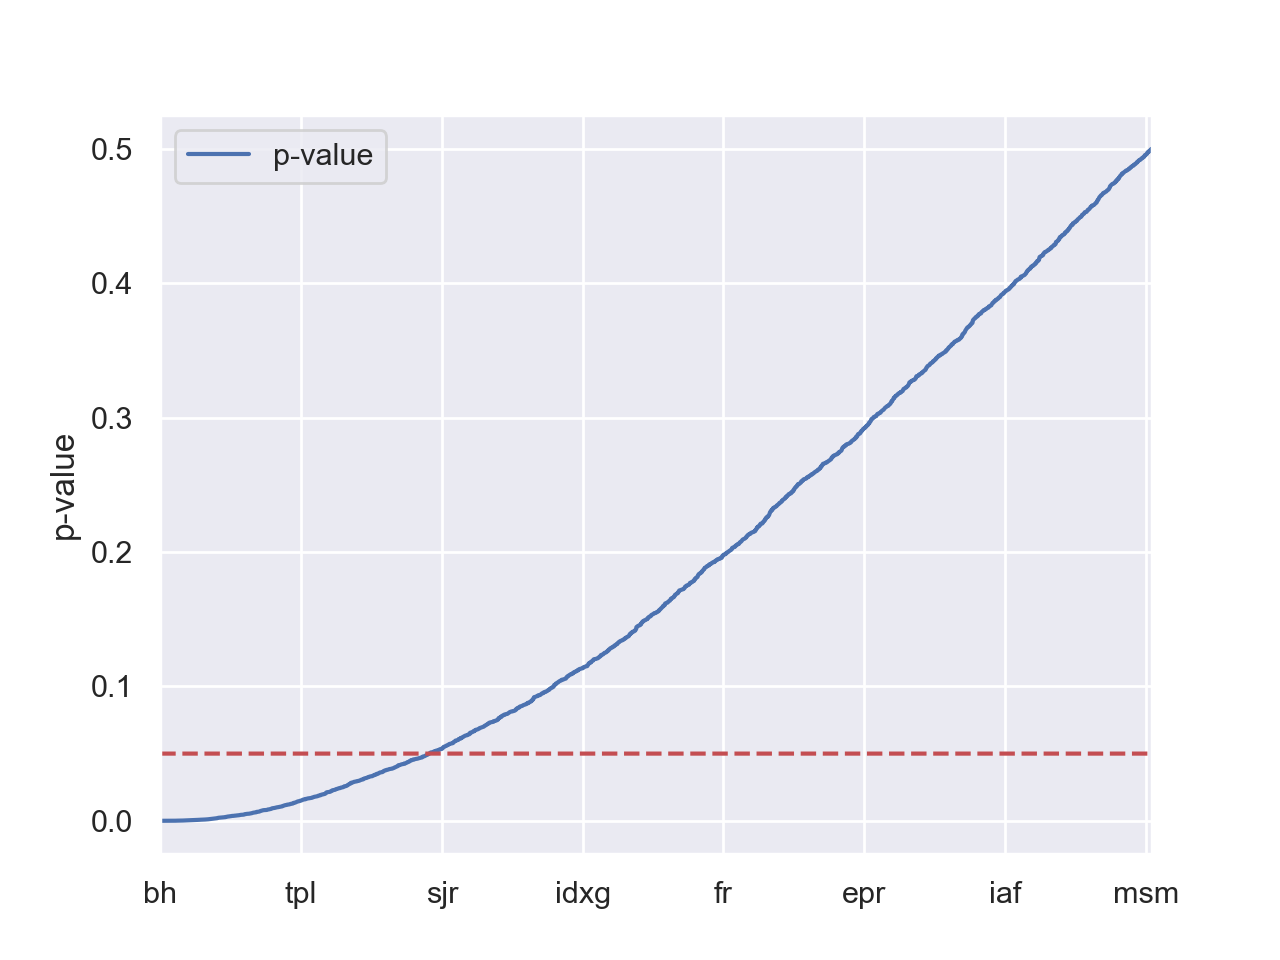

number of stocks with significant autocorrelation:  p-value    956
dtype: int64


In [286]:
from scipy.stats import t

df_autocorr = df_return.apply(lambda col: col.autocorr(1),axis=0)
df_autocorr = df_autocorr.sort_values(ascending=False)
df_autocorr.name = 'autocorr'
df_autocorr = df_autocorr.to_frame()
print(df_autocorr.sort_values('autocorr'))


df_autocorr.plot(y='autocorr')
plt.ylabel('autocorrelation')

df_N = (~df_return.isnull()).sum() # number of non-nan return

p_values = {ticker:1. - 
      t.cdf(np.abs(df_autocorr['autocorr'][ticker])*np.sqrt(df_N[ticker]-2)/
            np.sqrt(1-np.abs(df_autocorr['autocorr'][ticker])**2),df_N[ticker])
           for ticker in df_autocorr.index}

df_p_value = pd.Series(p_values).to_frame()
df_p_value.columns = ['p-value']
df_p_value = df_p_value.sort_values('p-value')

print(df_p_value)

df_p_value.plot(y='p-value')
plt.plot(np.arange(1,len(df_p_value)+1,1),0.05*np.ones(len(df_p_value)),'r--')
plt.ylabel('p-value')
plt.show()

print('number of stocks with significant autocorrelation: ',(df_p_value<0.05).sum())

The ranked autocorrelation plot above shows that there are stocks with significant autocorrelation (0.2 highest, -0.2 lowest): an indication of arbitrage opportunity. the p-value plot shows that there are a significant fraction of stocks in our universe that have a significant autocorrelation. This seems too good to be true! Let's visualize the autocorrelation of the most significant stock by plotting the return at t+1 vs return at t.

<IPython.core.display.Javascript object>


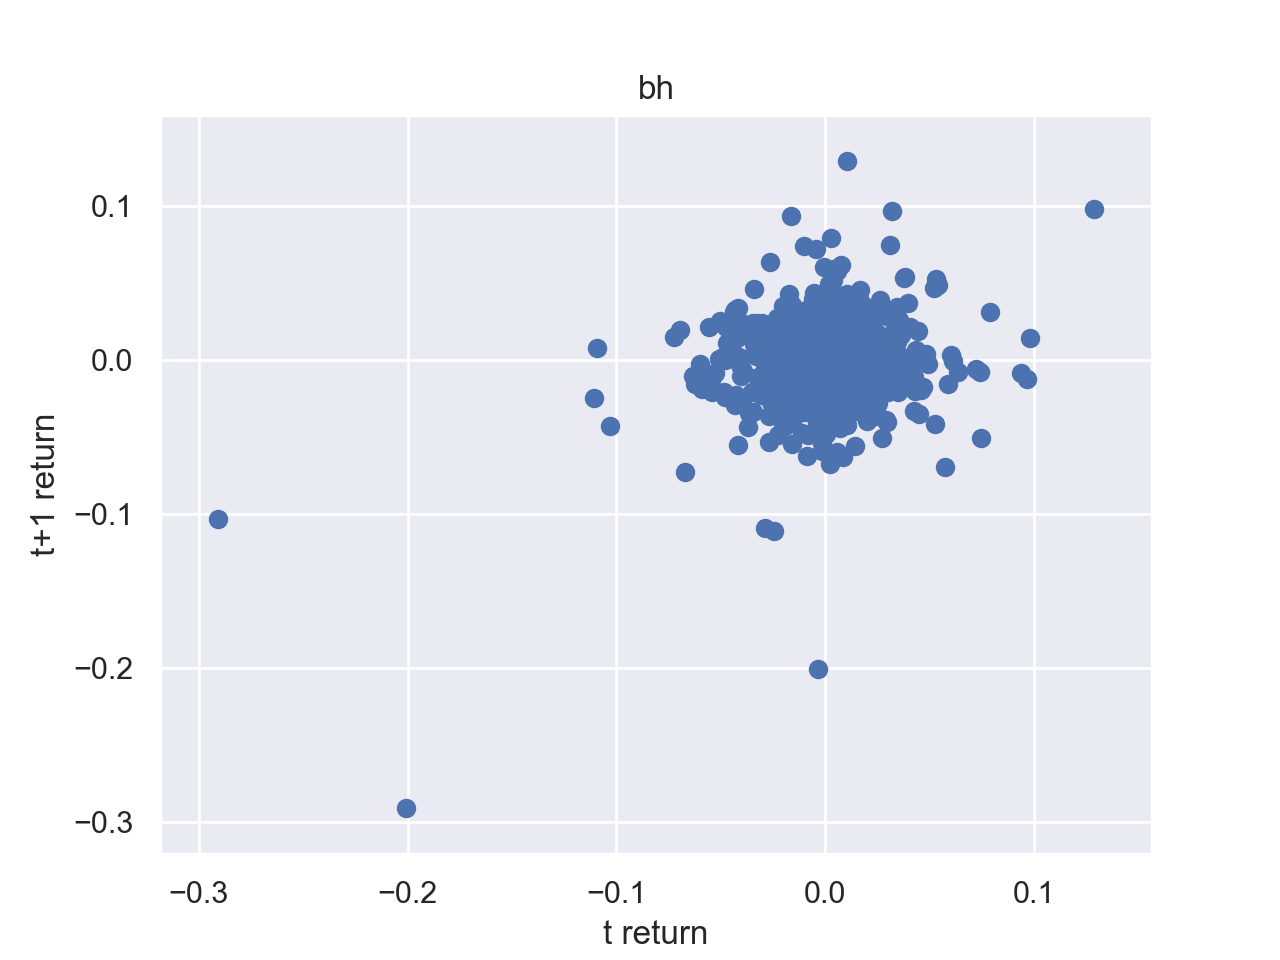

In [279]:
fig = plt.figure()
plt.title('bh')
plt.scatter(df_return['bh'].values[:-1],df_return['bh'].values[1:])
plt.ylabel('t+1 return')
plt.xlabel('t return')
plt.show()


The excessive autocorrelation for certain stocks are due to a few outliers. For the majority of the return, there is no autocorrelation. Let's remove the outliers and see if there are still significant autocorrelation.

The outliers are in and of themselves interesting. Therefore it is not always justified to remove the outliers.

<IPython.core.display.Javascript object>


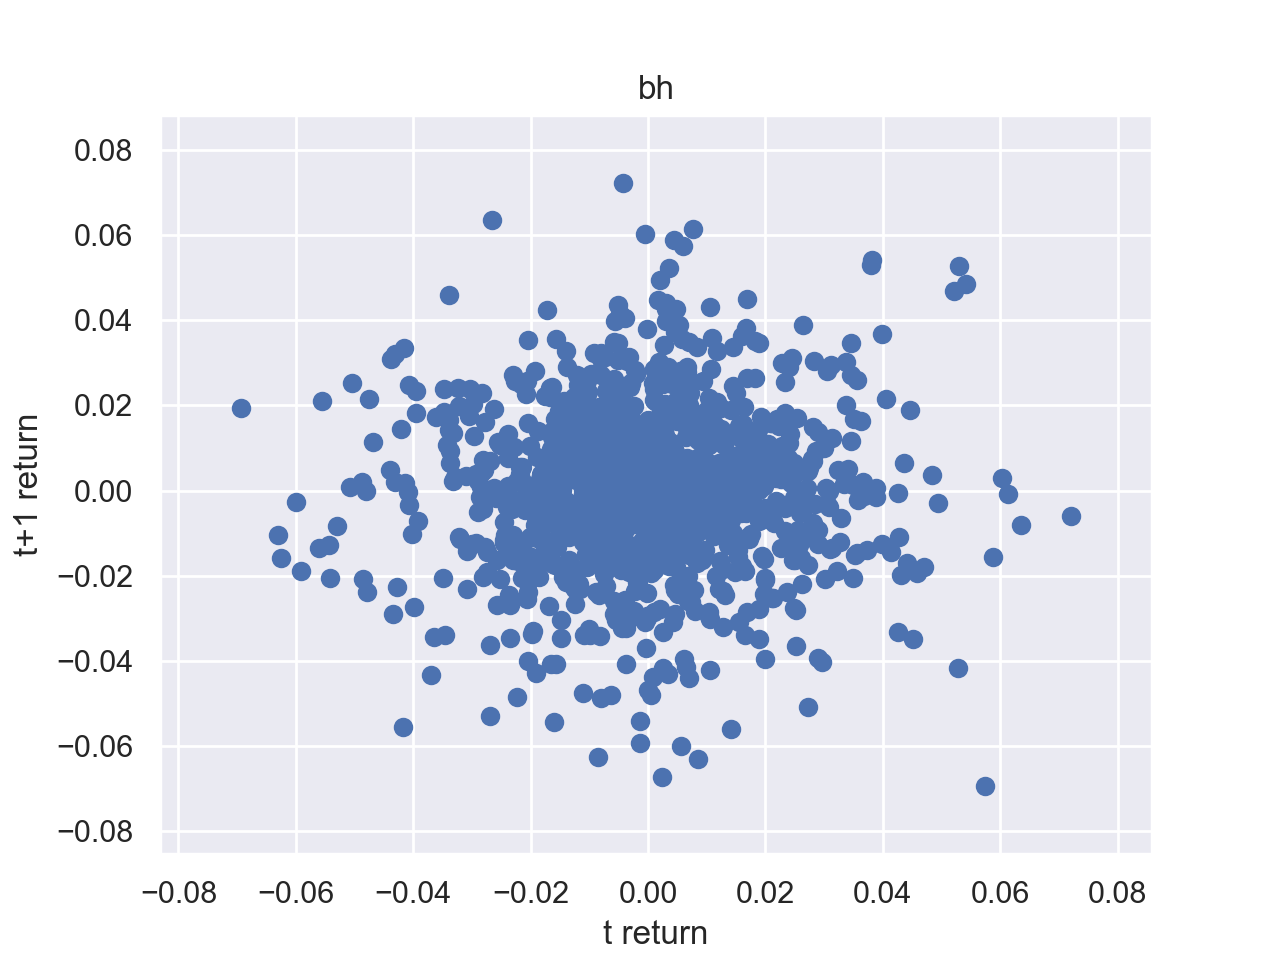

In [280]:
def upper_outlier(x):
    return  np.quantile(x,0.75) + 3*(np.quantile(x,0.75)-np.quantile(x,0.25))

def lower_outlier(x):
    return  np.quantile(x,0.25) - 3*(np.quantile(x,0.75)-np.quantile(x,0.25))

df_upper_outlier = df_return.apply(lambda x:upper_outlier(x))
df_lower_outlier = df_return.apply(lambda x:lower_outlier(x))

df_return_no_outlier = df_return[(df_return < df_upper_outlier) & (df_return > df_lower_outlier)]

fig = plt.figure()
plt.title('bh')
plt.scatter(df_return_no_outlier['bh'].values[:-1],df_return_no_outlier['bh'].values[1:])
plt.ylabel('t+1 return')
plt.xlabel('t return')
plt.show()

       autocorr
smbk  -0.140261
jcs   -0.119049
virc  -0.109897
sckt  -0.108042
jazz  -0.107945
...         ...
eqfn        NaN
hmg         NaN
hvt-a       NaN
whlm        NaN
cyccp       NaN

[3522 rows x 1 columns]


<IPython.core.display.Javascript object>


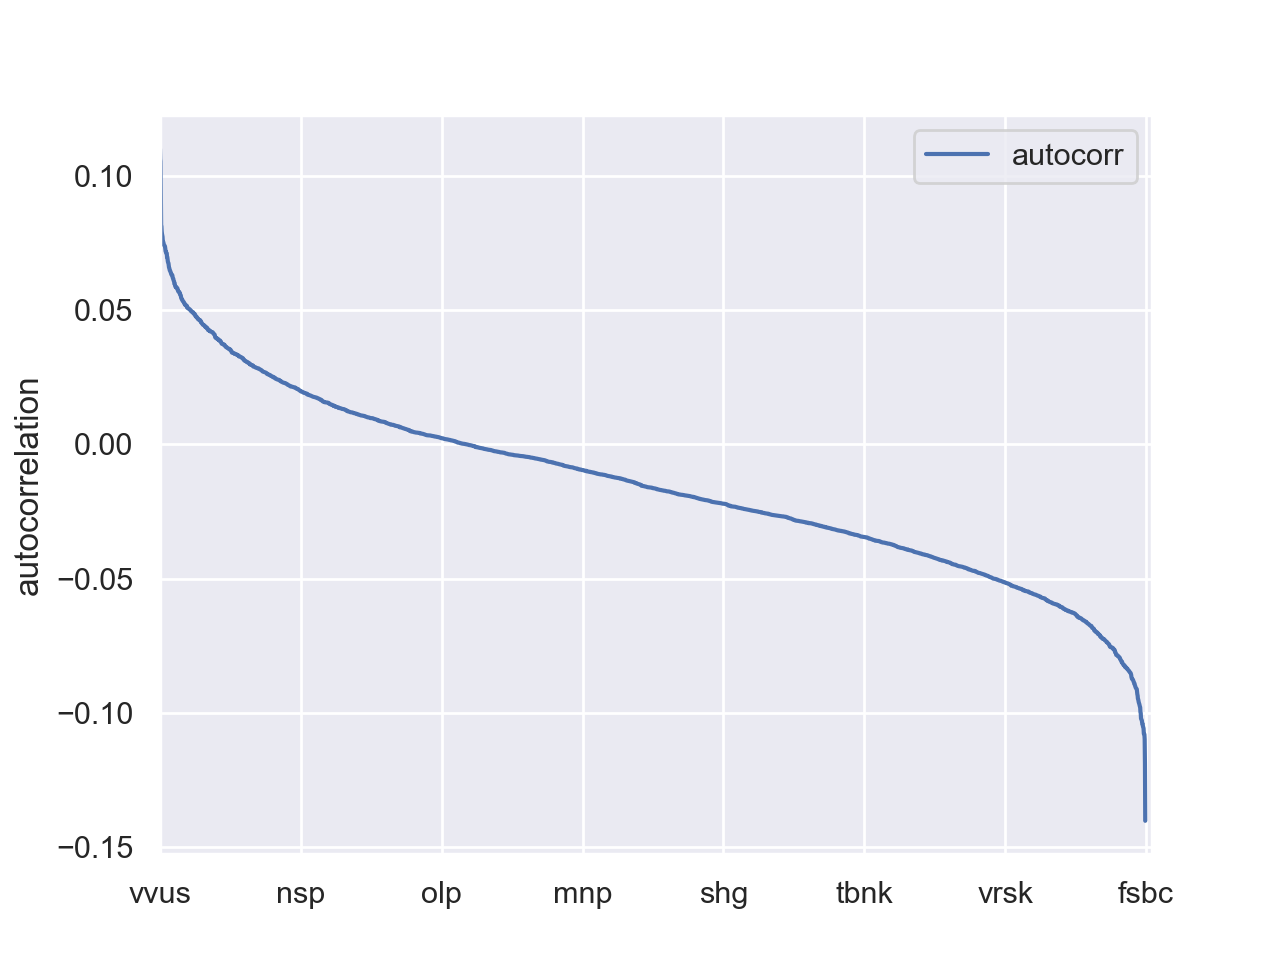

        p-value
smbk   0.000007
jcs    0.000013
vvus   0.000048
virc   0.000054
jazz   0.000070
...         ...
eqfn        NaN
hmg         NaN
hvt-a       NaN
whlm        NaN
cyccp       NaN

[3522 rows x 1 columns]


<IPython.core.display.Javascript object>


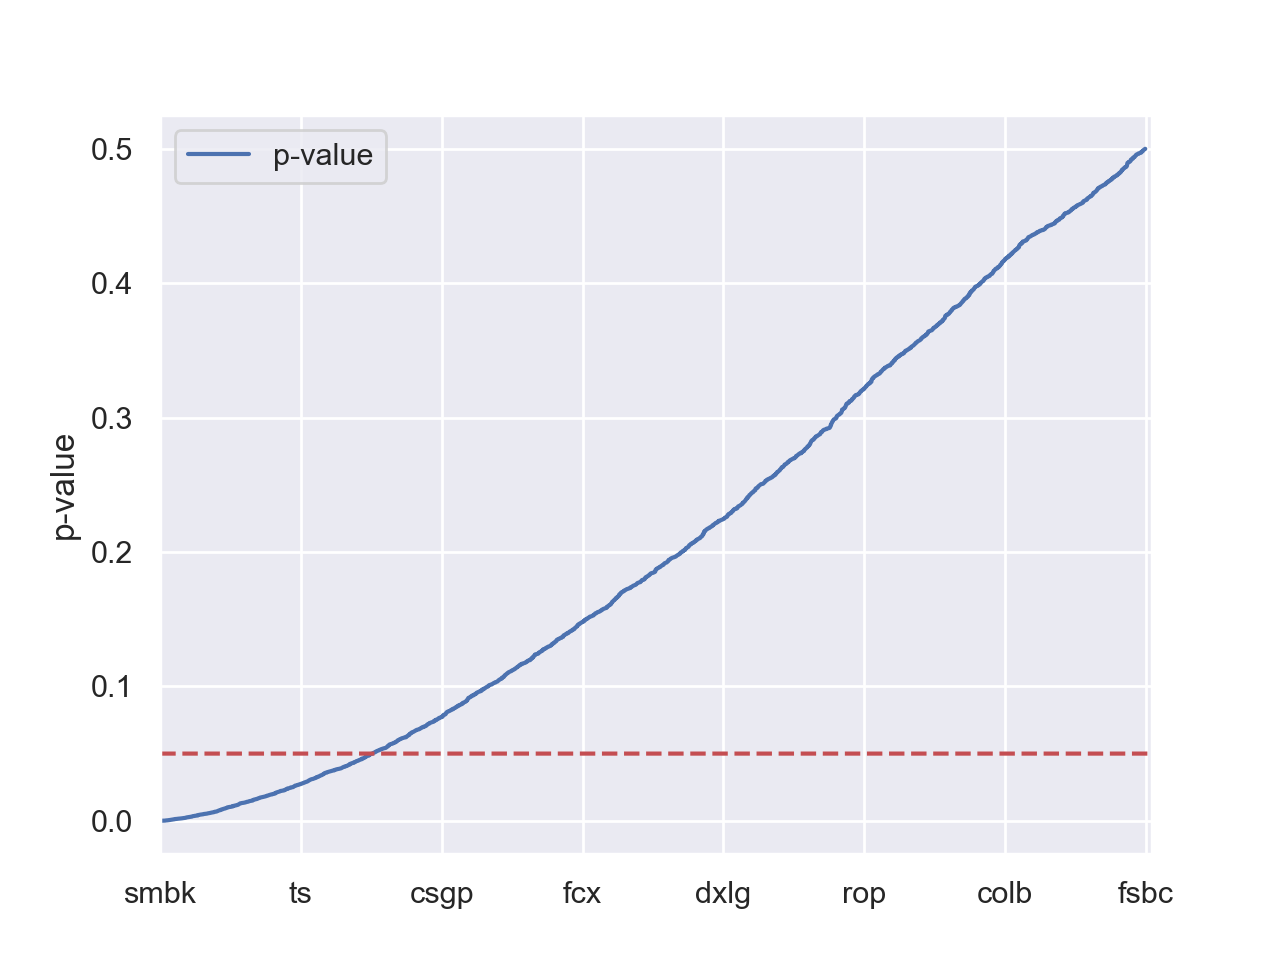

number of stocks with significant autocorrelation:  p-value    754
dtype: int64


In [281]:
df_autocorr_no_outlier = df_return_no_outlier.apply(lambda col: col.autocorr(1),axis=0)
df_autocorr_no_outlier = df_autocorr_no_outlier.sort_values(ascending=False)
df_autocorr_no_outlier.name = 'autocorr'
df_autocorr_no_outlier = df_autocorr_no_outlier.to_frame()
print(df_autocorr_no_outlier.sort_values('autocorr'))


df_autocorr_no_outlier.plot(y='autocorr')
plt.ylabel('autocorrelation')


df_N_no_outlier = (~df_return_no_outlier.isnull()).sum() # number of non-nan return

p_values_no_outlier = {ticker:1. - 
                      t.cdf(np.abs(df_autocorr_no_outlier['autocorr'][ticker])*np.sqrt(df_N_no_outlier[ticker]-2)/
                      np.sqrt(1-np.abs(df_autocorr_no_outlier['autocorr'][ticker])**2),df_N_no_outlier[ticker])
                      for ticker in df_autocorr_no_outlier.index}

df_p_value_no_outlier = pd.Series(p_values_no_outlier).to_frame()
df_p_value_no_outlier.columns = ['p-value']
df_p_value_no_outlier = df_p_value_no_outlier.sort_values('p-value')

print(df_p_value_no_outlier)

df_p_value_no_outlier.plot(y='p-value')
plt.plot(np.arange(1,len(df_p_value_no_outlier)+1,1),0.05*np.ones(len(df_p_value_no_outlier)),'r--')
plt.ylabel('p-value')
plt.show()

print('number of stocks with significant autocorrelation: ',(df_p_value_no_outlier<0.05).sum())

<IPython.core.display.Javascript object>


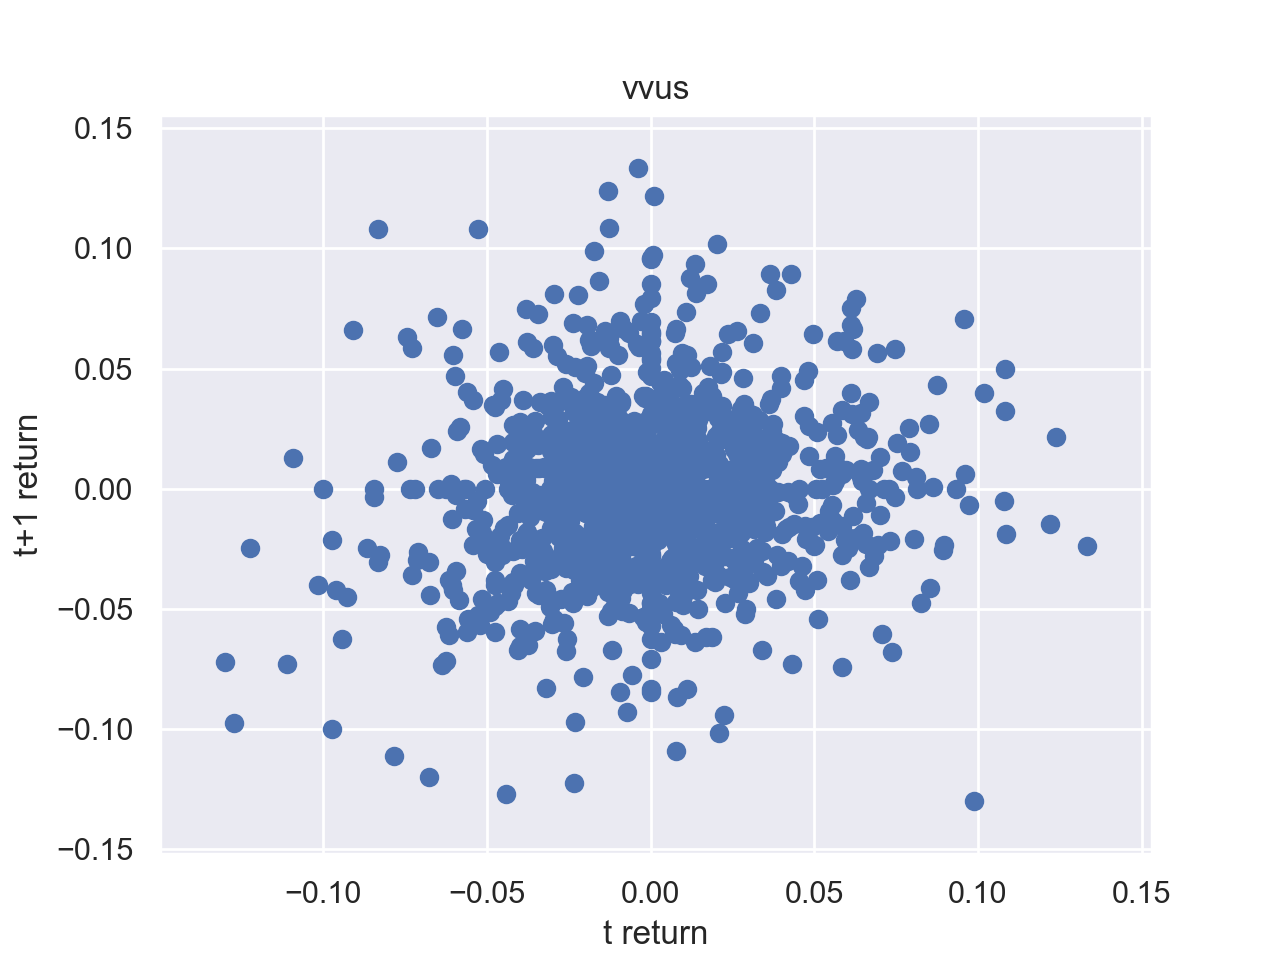

0.11021162296778819
p value:  4.842992754394704e-05


In [285]:
fig = plt.figure()
plt.title('vvus')
plt.scatter(df_return_no_outlier['vvus'].values[:-1],df_return_no_outlier['vvus'].values[1:])
plt.ylabel('t+1 return')
plt.xlabel('t return')
plt.show()

So even after removing the outliers, there are certain stocks that still exhibit significant autocorrelation. In fact, there are more stocks with negative autocorrelation than those with positive autocorrelation. This implies a tendency of stock to autoregress to its mean. However, does non-zero autocorrelation mean profitability? Note that the correlation might be too weak to really make a profit.

# Testing profitability
In order to profit from the autocorrelation, the trend must be consistent. When trading stocks, we can only measure the autocorrelation using data before today and there is no guarantee that the autocorrelation will persist in the future. Let's select a basket of stock candidates by requiring a significant autocorrelation from Jan 2010 to Dec 2010.

       autocorr
flt   -0.547563
qada  -0.523159
bita  -0.488892
gbab  -0.452487
hear  -0.395996
...         ...
cyccp       NaN
oncs        NaN
bui         NaN
carb        NaN
edf         NaN

[3522 rows x 1 columns]


<IPython.core.display.Javascript object>


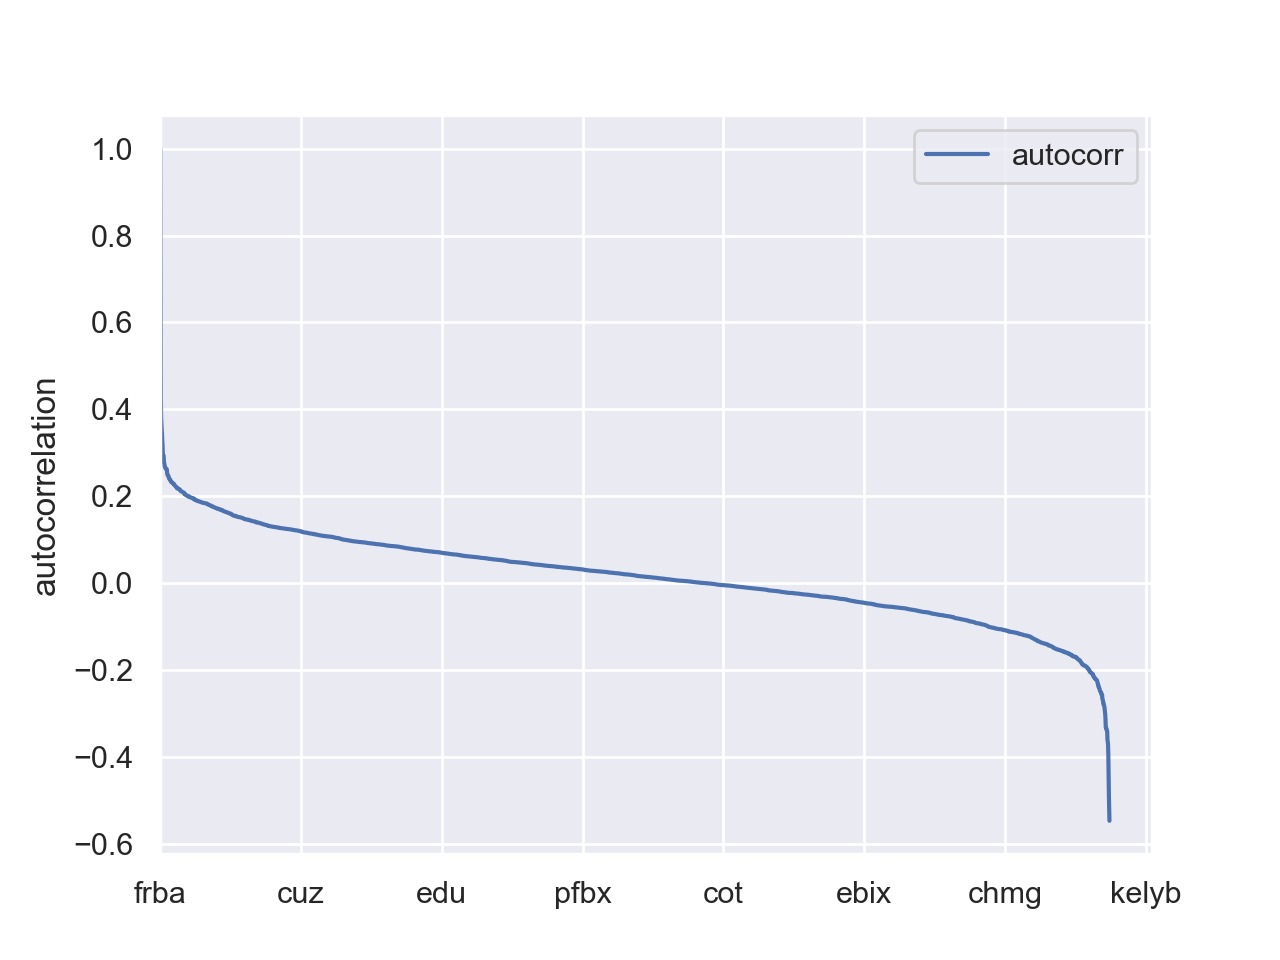

<IPython.core.display.Javascript object>


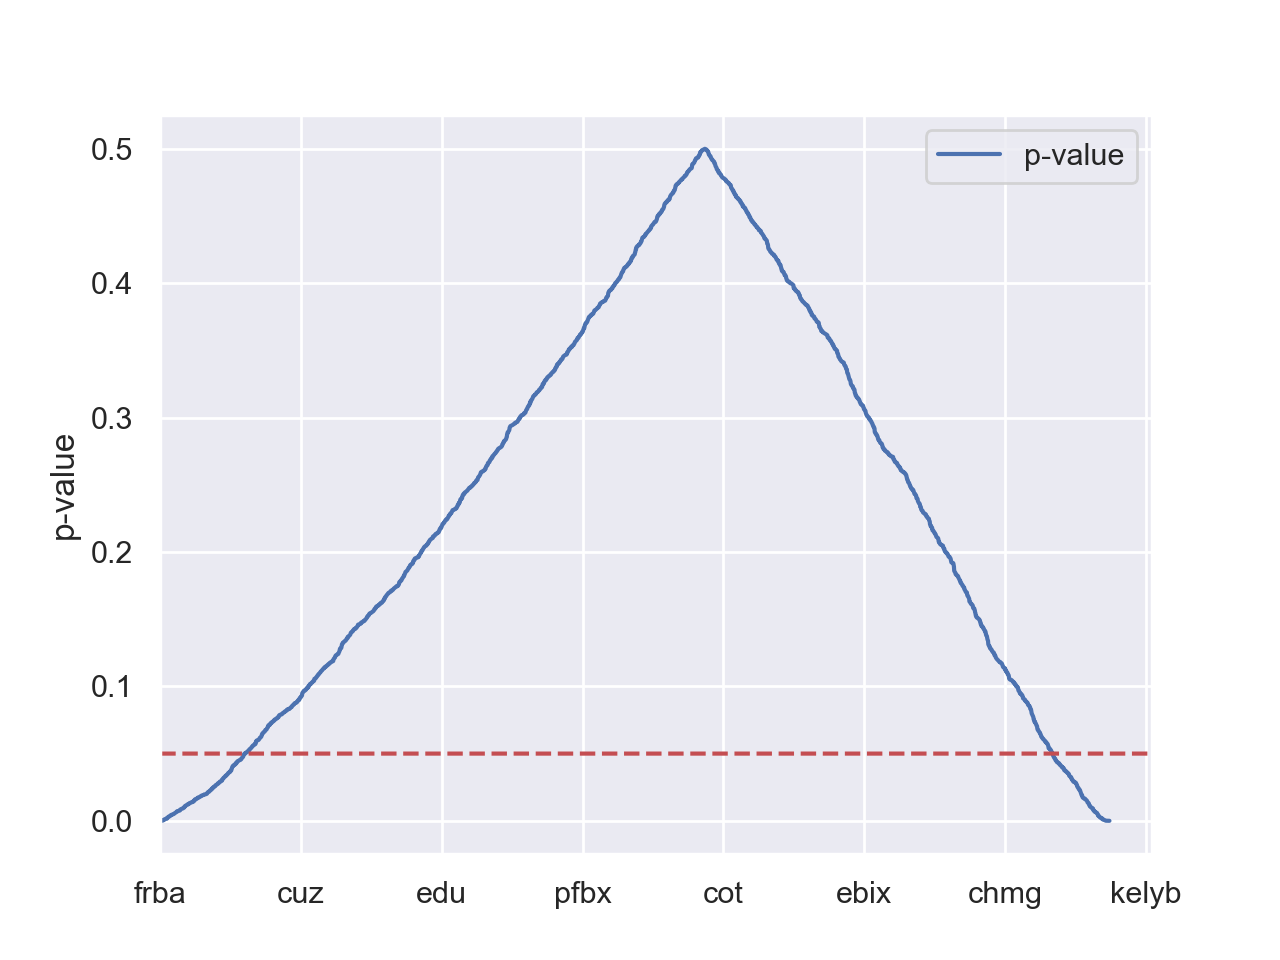

In [222]:
df_return_no_outlier.index = pd.to_datetime(df_return_no_outlier.index)
df_return_period = df_return_no_outlier[df_return_no_outlier.index.year == 2010]

df_autocorr_period = df_return_period.apply(lambda col: col.autocorr(1),axis=0)
df_autocorr_period = df_autocorr_period.sort_values(ascending=False)
df_autocorr_period.name = 'autocorr'
df_autocorr_period = df_autocorr_period.to_frame()
print(df_autocorr_period.sort_values('autocorr'))

df_autocorr_period.plot(y='autocorr')
plt.ylabel('autocorrelation')


p_values = []

N = len(df_return_period)

df_p_value_period = df_autocorr_period.apply(
    lambda x: 1. - t.cdf(np.abs(x)*np.sqrt(N-2)/np.sqrt(1-np.abs(x)**2),N))
df_p_value_period.columns = ['p-value']

df_p_value_period.plot(y='p-value')
plt.plot(np.arange(1,len(df_p_value_period)+1,1),0.05*np.ones(len(df_p_value_period)),'r--')
plt.ylabel('p-value')
plt.show()


In [6]:
df_return.index = pd.to_datetime(df_return.index)

significant_stocks = dict()
years = [2010 + i for i in range(2)]

for yr in years:
    period_mask = df_return.index.year == yr
    df_return_period = df_return[period_mask]
    N = len(df_return_period)
    
    # stocks with nan autocorr have zero daily returns throughout that period.
    df_autocorr_period = df_return_period.apply(lambda col: col.autocorr(1),axis=0)
    df_autocorr_period.name = 'autocorr'
    df_autocorr_period = df_autocorr_period.to_frame()
    df_p_value_period = df_autocorr_period.apply(
        lambda x: 1. - t.cdf(np.abs(x)*np.sqrt(N-2)/np.sqrt(1-np.abs(x)**2),N))
    df_p_value_period.columns = ['p-value']
    
    significant_stocks[yr] = df_p_value_period.index[df_p_value_period['p-value']<0.01].tolist()
    



//anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
//anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
//anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


In [7]:
consistent_stocks = set(significant_stocks[years[0]])
print(len(significant_stocks[years[0]]))

endyear = years[0] + 1
for yr in range(years[1],endyear+1):
    consistent_stocks = consistent_stocks.intersection(set(significant_stocks[yr]))
    print(len(significant_stocks[yr]))

print('stocks with consistent significant autocorrelation from Jan %i to Dec %i:'%(years[0],endyear))
print('')
print(consistent_stocks)

139
454
stocks with consistent significant autocorrelation from Jan 2010 to Dec 2011:

{'vtn', 'kmf', 'htbk', 'prgs', 'npo', 'kop', 'pcyo', 'hrb', 's', 'carv', 'boom', 'trox', 'mei', 'kfy', 'syke', 'mdca'}


In [10]:
import sys
sys.path.append('../load_data')

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from datetime import datetime
from LoadData_API import LoadData
from MakeFeatureMatrix import MakeFeatureMatrix
import time

startdate = datetime(2010, 1, 1)
enddate = datetime(2013, 1, 1)

for n,stock in enumerate(consistent_stocks):
    if n == 10:
        break
    df_X, df_Y = MakeFeatureMatrix(stock,startdate,enddate)
    print(df_X.shape)
    
    P = LoadData(startdate, enddate)
    df_stock = P.getstocks(stock)
    P.Aclose = df_stock['Adj Close']
    P.Volume = df_stock['Volume']
    
    N = len(df_X)
    Ntrain = int(2./3*N)
    Ntest = N - Ntrain

    X = df_X.values
    Y = df_Y.values
    Xtrain, Xtest = X[:Ntrain], X[Ntrain:]
    Ytrain, Ytest = Y[:Ntrain], Y[Ntrain:]
    
    params = {'n_estimators':[10,20,30,40,50],'max_depth':[2,3,4,5,6,7]}
    regr_cv = GridSearchCV(RandomForestRegressor(),
                           param_grid=params,
                           cv=5)

    regr_cv.fit(Xtrain,Ytrain)
    print(regr_cv.best_params_)

    Ytrain_pred = regr_cv.predict(Xtrain)
    Ytest_pred = regr_cv.predict(Xtest)

    print('r2 score: ',r2_score(Ytest,Ytest_pred),' rho: ',np.corrcoef(Xtrain[:,0],Ytrain)[0][1])


    
    

(750, 6)
{'max_depth': 2, 'n_estimators': 30}
r2 score:  -0.014432817258331454  rho:  -0.04538652035879868
(524, 6)
{'max_depth': 2, 'n_estimators': 50}
r2 score:  -0.10018693555311331  rho:  -0.04862036050596094
(750, 6)
{'max_depth': 2, 'n_estimators': 30}
r2 score:  -0.054375964272076915  rho:  -0.05851685882913004
(750, 6)
{'max_depth': 3, 'n_estimators': 40}
r2 score:  0.010572889116263418  rho:  -0.06747262951783056
(750, 6)
{'max_depth': 2, 'n_estimators': 20}
r2 score:  -0.011170093811791348  rho:  -0.08174135608174504
(750, 6)
{'max_depth': 2, 'n_estimators': 20}
r2 score:  -0.03552682016682773  rho:  -0.07510239936054158
(750, 6)
{'max_depth': 2, 'n_estimators': 40}
r2 score:  -0.025463747406704984  rho:  -0.04624198340958184
(750, 6)
{'max_depth': 2, 'n_estimators': 40}
r2 score:  -0.017877819562710506  rho:  -0.10528358236423761
(750, 6)
{'max_depth': 2, 'n_estimators': 20}
r2 score:  -0.047567767813190054  rho:  -0.038331407547735626
(750, 6)
{'max_depth': 2, 'n_estimators

Rising the correlation threshold (or lowering the p-value cutoff) to select stocks which have better autocorrelation. Sanity check: generate two time series with very weak autocorrelation. Do a autoregression and compare r2 score to that here.